In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import statsmodels.api as sm
from skbio.diversity import alpha_diversity, beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
from skbio.diversity.alpha import shannon


In [8]:
data = pd.read_csv('/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/data.csv')

In [9]:
otu_table_16S = pd.read_csv(
    '/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/OTU_table_16S.csv',
    header=0,  # Use the first row as headers
    index_col=0  # Set the first column as the index
)

otu_table_ITS = pd.read_csv(
    '/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/OTU_table_ITS.csv',
    header=0,  # Use the first row as headers
    index_col=0  # Set the first column as the index
)

In [10]:
# Merge Y_rs.dis with otu_table_16S
biome_16S = otu_table_16S.merge(data[['Sample_ID', 'Y_rs.dis']], on='Sample_ID', how='inner')
biome_16S.set_index(biome_16S.columns[0], inplace=True)  # Set column 0 as the index
# Merge Y_rs.dis with otu_table_ITS
biome_ITS = otu_table_ITS.merge(data[['Sample_ID', 'Y_rs.dis']], on='Sample_ID', how='inner')
biome_ITS.set_index(biome_ITS.columns[0], inplace=True)  # Set column 0 as the index

In [2]:
def perform_regression(data, otu_type, n_estimators=100, random_state=42):
    """
    Perform Random Forest regression to calculate feature importance (Mean Decrease Accuracy).

    Parameters:
        data (pd.DataFrame): DataFrame containing predictors and response variable.
        otu_type (str): Type of OTU ('fungal' or 'bacterial') to reflect in output name.
        n_estimators (int): Number of trees in the random forest (default: 100).
        random_state (int): Random seed for reproducibility (default: 42).

    Returns:
        pd.DataFrame: A DataFrame containing OTU and Mean Decrease Accuracy.
    """
    # Normalize all columns to a 0-1 range
    scaler = MinMaxScaler()
    data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

    # Extract response variable (Y_rs.dis) and predictors (all other columns)
    response = data_normalized['Y_rs.dis']
    predictors = data_normalized.drop(columns=['Y_rs.dis'])

    # Fit Random Forest regressor
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(predictors, response)

    # Calculate Mean Decrease Accuracy using permutation importance
    perm_importance = permutation_importance(
        rf_model, predictors, response, n_repeats=30, random_state=random_state, n_jobs=-1
    )

    # Extract feature importance and associated statistics
    importance_results = pd.DataFrame({
        'OTU': predictors.columns,
        'Mean_Decrease_Accuracy': perm_importance.importances_mean,
        'Std_Deviation': perm_importance.importances_std
    })

    # Sort by importance
    importance_results = importance_results.sort_values(by='Mean_Decrease_Accuracy', ascending=False)

    # Name the output DataFrame based on OTU type
    importance_results.name = f"{otu_type}_rf_reg"

    return importance_results

In [11]:
reg_biome_16S = perform_regression(biome_16S, 'bacterial')
reg_biome_ITS = perform_regression(biome_ITS, 'fungal')

KeyboardInterrupt: 

In [142]:
def reg_proc(regression_results):
    """
    Process regression results to count significant p-values and modify coefficients.
    
    Parameters:
        regression_results (pd.DataFrame): DataFrame containing 'OTU', 'Coefficient', and 'P_Value'.
    
    Returns:
        pd.DataFrame: Updated DataFrame with a new column 'Adjusted_Coefficient'.
    """
    # Count significant p-values
    significant_count = (regression_results['P_Value'] < 0.05).sum()
    print(f"Number of significant predictors: {significant_count}")
    
    # Create a new column 'Adjusted_Coefficient'
    regression_results['Adj_Coefficient'] = regression_results.apply(
        lambda row: row['Coefficient'] if row['P_Value'] < 0.05 else 0, axis=1
    )
    
    return regression_results

In [143]:
biome_16S = reg_proc(reg_biome_16S)
biome_ITS = reg_proc(reg_biome_ITS)

Number of significant predictors: 2536
Number of significant predictors: 171
Number of significant predictors: 2536
Number of significant predictors: 171


In [144]:
def bcon_index(regression_results, abundance_table, otu_type):
    """
    Calculate the BC index (bacterial or fungal) for each sample, normalizing abundances as relative abundances.
    
    Parameters:
        regression_results (pd.DataFrame): DataFrame containing OTUs and their 'Adj_Coefficient'.
        abundance_table (pd.DataFrame): Abundance table with OTUs as columns and Sample_ID as index.
        otu_type (str): Type of OTU ('fungal' or 'bacterial') to name the output column.
    
    Returns:
        pd.DataFrame: DataFrame with Sample_ID as rows and BC index as a column.
    """
    # Ensure Adj_Coefficient column exists
    if 'Adj_Coefficient' not in regression_results.columns:
        raise ValueError("The regression results must include an 'Adj_Coefficient' column.")
    
    # Normalize the abundance table to relative abundances
    relative_abundance_table = abundance_table.div(abundance_table.sum(axis=1), axis=0)
    
    # Filter for OTUs with non-zero Adj_Coefficient
    significant_otus = regression_results[regression_results['Adj_Coefficient'] != 0]

    # Map Adj_Coefficient to the abundance table columns
    coef_dict = significant_otus.set_index('OTU')['Adj_Coefficient'].to_dict()

    # Ensure only relevant OTUs are used
    filtered_abundance_table = relative_abundance_table[relative_abundance_table.columns.intersection(coef_dict.keys())]
    
    # Multiply relative abundances by the respective Adj_Coefficients
    bci_values = filtered_abundance_table.multiply(filtered_abundance_table.columns.map(coef_dict), axis=1).sum(axis=1)
    
    # Create a DataFrame with the BCI values
    bci_df = pd.DataFrame(bci_values, columns=[f"{otu_type}_BCI"])
    bci_df.index.name = 'Sample_ID'
    
    return bci_df

In [145]:
bacterial_bci = bcon_index(reg_biome_16S, otu_table_16S, 'bacterial')
fungal_bci = bcon_index(reg_biome_ITS, otu_table_ITS, 'fungal')

In [146]:
# Function to normalize BCI values
def normalize_bci(bci_df):
    """
    Normalize BC index values to the range
    
    Parameters:
        bci_df (pd.DataFrame): DataFrame containing BC index values with Sample_ID as index.
    
    Returns:
        pd.DataFrame: Normalized BC index values in the range [-1, 1].
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    bci_normalized = scaler.fit_transform(bci_df)
    normalized_df = pd.DataFrame(bci_normalized, index=bci_df.index, columns=bci_df.columns)
    return normalized_df


In [147]:
bacterial_bci = normalize_bci(bacterial_bci)
fungal_bci = normalize_bci(fungal_bci)

In [148]:
def add_bci_to_data(data, bacterial_bci, fungal_bci):
    """
    Add bacterial_BCI and fungal_BCI columns to the data, prefixed with 'P_'.
    
    Parameters:
        data (pd.DataFrame): Original data with 'Sample_ID' as a column.
        bacterial_bci (pd.DataFrame): DataFrame containing bacterial_BCI values with Sample_ID as the index.
        fungal_bci (pd.DataFrame): DataFrame containing fungal_BCI values with Sample_ID as the index.
    
    Returns:
        pd.DataFrame: Updated data with P_bacterial_BCI and P_fungal_BCI columns.
    """
   
    # Merge bacterial BCI into the data
    data = data.merge(bacterial_bci, left_on='Sample_ID', right_index=True, how='left')
    
    # Merge fungal BCI into the data
    data = data.merge(fungal_bci, left_on='Sample_ID', right_index=True, how='left')
    
    return data

In [149]:
merged_data = add_bci_to_data(data, bacterial_bci, fungal_bci)

In [150]:
def duplicate_bci_scores(data, bacterial_bci, fungal_bci, equivalence_table):
    """
    Duplicate equivalent BC index scores to fill NaN values based on the equivalence table.
    
    Parameters:
        data (pd.DataFrame): Original data containing 'Sample_ID' as a column.
        bacterial_bci (pd.DataFrame): DataFrame with bacterial BCI indexed by Sample_ID.
        fungal_bci (pd.DataFrame): DataFrame with fungal BCI indexed by Sample_ID.
        equivalence_table (pd.DataFrame): DataFrame with columns 'fungal_Sample_ID' and 'bacterial_Sample_ID'.
    
    Returns:
        pd.DataFrame: Updated data with P_bacterial_BCI and P_fungal_BCI columns filled based on equivalence.
    """
    # Rename BCI columns for clarity
    bacterial_bci = bacterial_bci.rename(columns={'bacterial_BCI': 'P_bacterial_BCI'})
    fungal_bci = fungal_bci.rename(columns={'fungal_BCI': 'P_fungal_BCI'})
    
    # Add P_bacterial_BCI and P_fungal_BCI to the data
    data = data.merge(bacterial_bci, left_on='Sample_ID', right_index=True, how='left')
    data = data.merge(fungal_bci, left_on='Sample_ID', right_index=True, how='left')

    # Create a mapping dictionary from the equivalence table
    fungal_to_bacterial = equivalence_table.set_index('fungal_Sample_ID')['bacterial_Sample_ID'].to_dict()
    bacterial_to_fungal = equivalence_table.set_index('bacterial_Sample_ID')['fungal_Sample_ID'].to_dict()

    # Fill missing fungal BCI using bacterial BCI
    for i, row in data.iterrows():
        if pd.isna(row['P_fungal_BCI']) and row['Sample_ID'] in bacterial_to_fungal:
            equivalent_id = bacterial_to_fungal[row['Sample_ID']]
            equivalent_score = data.loc[data['Sample_ID'] == equivalent_id, 'P_fungal_BCI']
            if not equivalent_score.empty:
                data.at[i, 'P_fungal_BCI'] = equivalent_score.values[0]

    # Fill missing bacterial BCI using fungal BCI
    for i, row in data.iterrows():
        if pd.isna(row['P_bacterial_BCI']) and row['Sample_ID'] in fungal_to_bacterial:
            equivalent_id = fungal_to_bacterial[row['Sample_ID']]
            equivalent_score = data.loc[data['Sample_ID'] == equivalent_id, 'P_bacterial_BCI']
            if not equivalent_score.empty:
                data.at[i, 'P_bacterial_BCI'] = equivalent_score.values[0]

    return data

In [151]:
equivalence_table = pd.read_csv('/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/eq_table.csv')

In [152]:
merged_data = duplicate_bci_scores(data, bacterial_bci, fungal_bci, equivalence_table)

In [153]:
def eco_metrics(abundance_table, otu_type, metric="braycurtis"):
    """
    Calculate ecological metrics (alpha diversity, evenness, and beta diversity) for microbial communities.

    Parameters:
        abundance_table (pd.DataFrame): Abundance table with OTUs as columns and Sample_ID as index.
        otu_type (str): Type of OTU ('fungal' or 'bacterial') to name the output columns.
        metric (str): Distance metric for beta diversity (default: 'braycurtis').

    Returns:
        pd.DataFrame: DataFrame with alpha diversity, beta diversity, and evenness as columns.
    """
    # Ensure no empty rows
    abundance_table = abundance_table.loc[abundance_table.sum(axis=1) > 0]
    
    # Alpha diversity (Shannon Index)
    alpha_div = abundance_table.apply(lambda row: shannon(row.values), axis=1)
    
    # Evenness calculation (Pielou's evenness)
    total_abundance = abundance_table.sum(axis=1)
    evenness = alpha_div / np.log(total_abundance.replace(0, 1))
    
    # Beta diversity (distance matrix)
    beta_div = beta_diversity(metric, abundance_table, ids=abundance_table.index)
    beta_div_mean = beta_div.to_data_frame().mean(axis=1)  # Calculate mean beta diversity for each sample

    # Construct the output DataFrame
    metrics_df = pd.DataFrame({
        f"{otu_type}_alpha_diversity": alpha_div,
        f"{otu_type}_evenness": evenness,
        f"{otu_type}_beta_diversity": beta_div_mean
    }, index=abundance_table.index)

    return metrics_df

In [154]:
bacterial_metrics = eco_metrics(otu_table_16S, otu_type='bacterial')
fungal_metrics = eco_metrics(otu_table_ITS, otu_type='fungal')

In [155]:
def add_metrics_to_data(data, bacterial_metrics, fungal_metrics):
    """
    Add bacterial and fungal ecological metrics to the data, with columns prefixed by 'P_'.
    
    Parameters:
        data (pd.DataFrame): Original data with 'Sample_ID' as a column.
        bacterial_metrics (pd.DataFrame): DataFrame containing bacterial metrics with Sample_ID as the index.
        fungal_metrics (pd.DataFrame): DataFrame containing fungal metrics with Sample_ID as the index.
    
    Returns:
        pd.DataFrame: Updated data with prefixed ecological metrics columns.
    """
    # Ensure prefix for bacterial metrics
    bacterial_metrics = bacterial_metrics.add_prefix("P_")
    
    # Ensure prefix for fungal metrics
    fungal_metrics = fungal_metrics.add_prefix("P_")
    
    # Merge bacterial metrics into the data
    data = data.merge(bacterial_metrics, left_on='Sample_ID', right_index=True, how='left')
    
    # Merge fungal metrics into the data
    data = data.merge(fungal_metrics, left_on='Sample_ID', right_index=True, how='left')
    
    return data

In [156]:
merged_data = add_metrics_to_data(merged_data, bacterial_metrics, fungal_metrics)

In [157]:
def duplicate_metrics(data, bacterial_metrics, fungal_metrics, equivalence_table):
    """
    Duplicate equivalent metrics to fill NaN values based on the equivalence table.

    Parameters:
        data (pd.DataFrame): Original data containing 'Sample_ID' as a column.
        bacterial_metrics (pd.DataFrame): DataFrame with bacterial metrics indexed by Sample_ID.
        fungal_metrics (pd.DataFrame): DataFrame with fungal metrics indexed by Sample_ID.
        equivalence_table (pd.DataFrame): DataFrame with columns 'fungal_Sample_ID' and 'bacterial_Sample_ID'.

    Returns:
        pd.DataFrame: Updated data with bacterial and fungal metrics filled based on equivalence.
    """
    # Merge bacterial and fungal metrics into the main data
    data = data.merge(bacterial_metrics, left_on='Sample_ID', right_index=True, how='left')
    data = data.merge(fungal_metrics, left_on='Sample_ID', right_index=True, how='left')

    # Create mappings from the equivalence table
    fungal_to_bacterial = equivalence_table.set_index('fungal_Sample_ID')['bacterial_Sample_ID'].to_dict()
    bacterial_to_fungal = equivalence_table.set_index('bacterial_Sample_ID')['fungal_Sample_ID'].to_dict()

    # Fill missing fungal metrics using bacterial metrics
    missing_fungal = data[data['fungal_alpha_diversity'].isna()]
    for idx, row in missing_fungal.iterrows():
        if row['Sample_ID'] in bacterial_to_fungal:
            equivalent_id = bacterial_to_fungal[row['Sample_ID']]
            equivalent_metrics = data[data['Sample_ID'] == equivalent_id].filter(like="fungal_")
            if not equivalent_metrics.empty:
                data.loc[idx, equivalent_metrics.columns] = equivalent_metrics.values[0]

    # Fill missing bacterial metrics using fungal metrics
    missing_bacterial = data[data['bacterial_alpha_diversity'].isna()]
    for idx, row in missing_bacterial.iterrows():
        if row['Sample_ID'] in fungal_to_bacterial:
            equivalent_id = fungal_to_bacterial[row['Sample_ID']]
            equivalent_metrics = data[data['Sample_ID'] == equivalent_id].filter(like="bacterial_")
            if not equivalent_metrics.empty:
                data.loc[idx, equivalent_metrics.columns] = equivalent_metrics.values[0]

    return data

In [158]:
merged_data = duplicate_metrics(merged_data, bacterial_metrics, fungal_metrics, equivalence_table)

In [159]:
def add_p_prefix(data):
    """
    Add the prefix 'P_' to column names in the DataFrame that start with 'fungal' or 'bacterial'
    and do not already start with 'P_'.

    Parameters:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with updated column names.
    """
    # Update column names
    data = data.rename(
        columns=lambda col: f"P_{col}" if col.startswith(('fungal', 'bacterial')) and not col.startswith('P_') else col
    )
    return data

In [160]:
merged_data = add_p_prefix(merged_data)
merged_data.set_index(merged_data.columns[0], inplace=True)

In [161]:
classifiers = [col for col in merged_data.columns if col.startswith('K_')]
predictors = [col for col in merged_data.columns if col.startswith('P_')]
target = [col for col in merged_data.columns if col.startswith('Y_')]

In [162]:
# Impute missing values for predictors
imputer = KNNImputer(n_neighbors=5)
merged_data[predictors] = imputer.fit_transform(merged_data[predictors])

In [163]:
# Scale predictors
scaler = StandardScaler()
merged_data[predictors] = scaler.fit_transform(merged_data[predictors])

In [164]:
# Create a binary classification target
merged_data['Class'] = np.where(merged_data[target].values > 10, 'Conducive', 'Suppressive')
merged_data['Class'] = merged_data['Class'].map({'Suppressive': 0, 'Conducive': 1})

In [165]:
# Split the data into training and testing sets
X = merged_data[predictors]
y = merged_data['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [166]:
# Train the ANN model
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, verbose=True)
ann.fit(X_train, y_train)

Iteration 1, loss = 0.75631441
Iteration 2, loss = 0.64343128
Iteration 3, loss = 0.56761675
Iteration 4, loss = 0.51612661
Iteration 5, loss = 0.47944667
Iteration 6, loss = 0.44712491
Iteration 7, loss = 0.42231552
Iteration 8, loss = 0.40316892
Iteration 9, loss = 0.38737444
Iteration 10, loss = 0.37355122
Iteration 11, loss = 0.36373038
Iteration 12, loss = 0.35351239
Iteration 13, loss = 0.34573722
Iteration 14, loss = 0.33784978
Iteration 15, loss = 0.32972300
Iteration 16, loss = 0.32211762
Iteration 17, loss = 0.31567189
Iteration 18, loss = 0.30984354
Iteration 19, loss = 0.30412830
Iteration 20, loss = 0.29840040
Iteration 21, loss = 0.29207880
Iteration 22, loss = 0.28577080
Iteration 23, loss = 0.27955992
Iteration 24, loss = 0.27440213
Iteration 25, loss = 0.26890412
Iteration 26, loss = 0.26339203
Iteration 27, loss = 0.25873919
Iteration 28, loss = 0.25354671
Iteration 29, loss = 0.24881661
Iteration 30, loss = 0.24289851
Iteration 31, loss = 0.23787334
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42,
              verbose=True)

In [167]:
# Predict on the test set
y_pred = ann.predict(X_test)


Confusion Matrix:
[[26  8]
 [ 8 73]]


Confusion Matrix:
[[26  8]
 [ 8 73]]


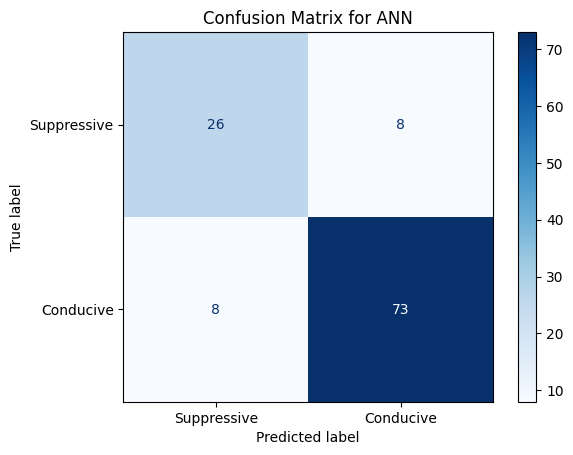

In [168]:
# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=ann.classes_)
print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Suppressive', 'Conducive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for ANN')
plt.show()

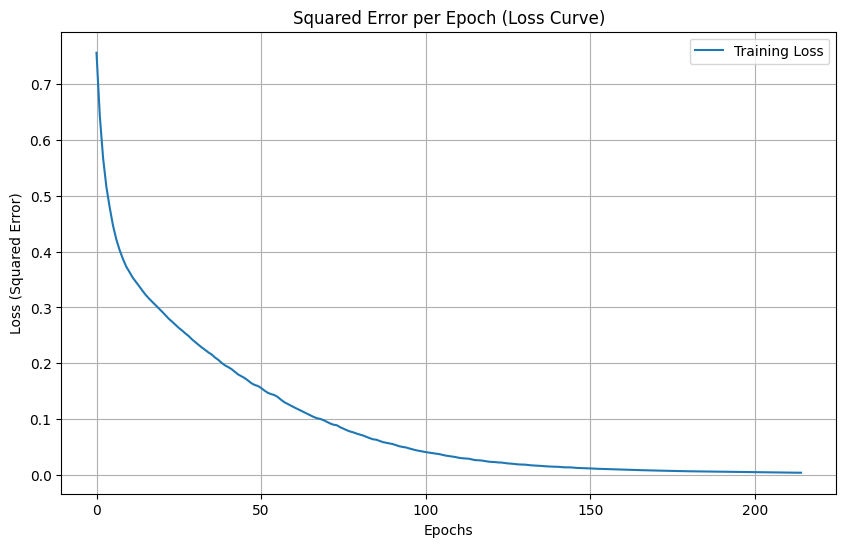

In [169]:
# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(ann.loss_curve_, label='Training Loss')
plt.title('Squared Error per Epoch (Loss Curve)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

In [170]:
# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        34
           1       0.90      0.90      0.90        81

    accuracy                           0.86       115
   macro avg       0.83      0.83      0.83       115
weighted avg       0.86      0.86      0.86       115



Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        34
           1       0.90      0.90      0.90        81

    accuracy                           0.86       115
   macro avg       0.83      0.83      0.83       115
weighted avg       0.86      0.86      0.86       115

